Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0211 - val_loss: 0.0120
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - val_loss: 0.0058
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 0.0050
Epoch 8/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 9/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 10/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 11/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 12/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

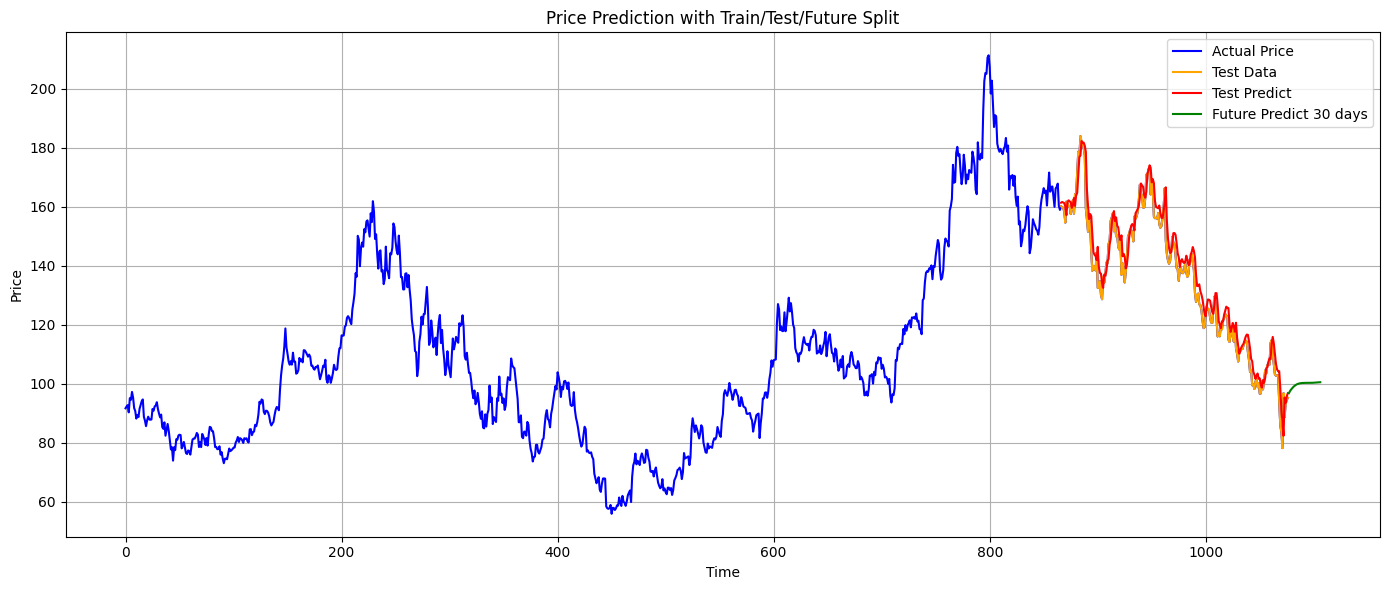

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

# Đọc dữ liệu
file_path = "../../Dataset/amd_stock_price.csv"
df = pd.read_csv(file_path)
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df = df.sort_values("Date").reset_index(drop=True)

# Xử lý Volume và Change %
def parse_volume(vol):
    if isinstance(vol, str):
        if 'M' in vol:
            return float(vol.replace('M', '').replace(',', '')) * 1e6
        elif 'B' in vol:
            return float(vol.replace('B', '').replace(',', '')) * 1e9
    return np.nan

df["Vol."] = df["Vol."].apply(parse_volume)
df["Change %"] = df["Change %"].str.replace('%', '').astype(float)

# Lọc dữ liệu cần thiết
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
df = df[features].dropna()

# Chuẩn hóa
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

# Tạo chuỗi thời gian
window_size = 30
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i - window:i])
        y.append(data[i, 0])  # Price
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(data_scaled, window_size)

# Chia dữ liệu train/val/test
n_samples = X_all.shape[0]
train_size = int(n_samples * 0.7)
val_size = int(n_samples * 0.1)

X_train = X_all[:train_size]
y_train = y_all[:train_size]
X_val = X_all[train_size:train_size + val_size]
y_val = y_all[train_size:train_size + val_size]
X_test = X_all[train_size + val_size:]
y_test = y_all[train_size + val_size:]

# Mô hình
model = Sequential([
    Input(shape=(window_size, X_train.shape[2])),
    LSTM(100, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Huấn luyện
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=200, batch_size=16,
          validation_data=(X_val, y_val), callbacks=[early_stop], verbose=1)

# Dự đoán trên tập test
y_pred_scaled = model.predict(X_test)
price_scaler = MinMaxScaler()
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
y_pred = price_scaler.inverse_transform(y_pred_scaled)
y_true = price_scaler.inverse_transform(y_test.reshape(-1, 1))

# Dự đoán tương lai 30 ngày
n_future_days = 30
last_sequence = X_test[-1:]

predictions = []
for _ in range(n_future_days):
    pred_scaled = model.predict(last_sequence)
    predictions.append(pred_scaled[0, 0])
    next_input = last_sequence.copy()
    next_input = np.roll(next_input, -1, axis=1)
    next_input[0, -1, :] = last_sequence[0, -1, :]
    next_input[0, -1, 0] = pred_scaled[0, 0]
    last_sequence = next_input

future_predictions = price_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Chuẩn bị vẽ biểu đồ đầy đủ
prices = df['Price'].values.reshape(-1, 1)
prices_inverse = price_scaler.inverse_transform(scaler.transform(df)[:, 0].reshape(-1, 1))

train_idx = range(window_size, window_size + len(y_train))
val_idx = range(train_idx.stop, train_idx.stop + len(y_val))
test_idx = range(val_idx.stop, val_idx.stop + len(y_test))
future_idx = range(test_idx.stop, test_idx.stop + n_future_days)

# Test predict
test_predict_full = np.empty_like(prices_inverse)
test_predict_full[:] = np.nan
test_predict_full[test_idx] = y_pred

# Future predict
future_predict_full = np.empty_like(prices_inverse)
future_predict_full[:] = np.nan
future_predict_full = np.vstack([
    future_predict_full,
    np.full((n_future_days, 1), np.nan)
])
future_predict_full[future_idx] = future_predictions.reshape(-1, 1)

# Actual giá kéo dài để khớp chiều dài
actual_extended = np.vstack([prices_inverse, np.full((n_future_days, 1), np.nan)])

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.plot(actual_extended, label='Actual Price', color='blue')
plt.plot(test_idx, prices_inverse[test_idx], label='Test Data', color='orange')
plt.plot(test_predict_full, label='Test Predict', color='red')
plt.plot(future_predict_full, label='Future Predict 30 days', color='green')

plt.title("Price Prediction with Train/Test/Future Split")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
